<a href="https://colab.research.google.com/github/Weverton-Vitor/multiclass-semantic-segmentation-unet/blob/main/multiclass_semantic_segmentation_with_tensorlfow_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass segmentation using TensorFlow

## 1. Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2. Import Libs

In [2]:
import os
import zipfile
import glob
import random

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, normalize
from PIL import Image, ImageSequence
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


## 3. Open and preprocess the dataset
In this dataset we already have the masks, so we can just open them

> Become one with the data

### 3.1 Unzip the dataset

In [3]:
dataset_zip_path = "/content/drive/MyDrive/Colab Notebooks/My Projects/datasets/sandstone_data_for_ML.zip"
with zipfile.ZipFile(dataset_zip_path) as file:
  file.extractall('./')

In [4]:
# Resize the images to this values
SIZE_X = 128
SIZE_Y = 128

# Num of classes
n_classes = 4

def get_images_from_directory(images_path: str) -> list:
  images = []
  image = Image.open(images_path)


  for frame in range(image.n_frames):
    image.seek(frame)

    images.append(image.copy())

  return images


In [5]:
images = get_images_from_directory('/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif')
masks = get_images_from_directory('/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif')

In [6]:
len(images), len(masks)

(1600, 1600)

In [7]:
images[0].size

(128, 128)

### 3.2 View some samples

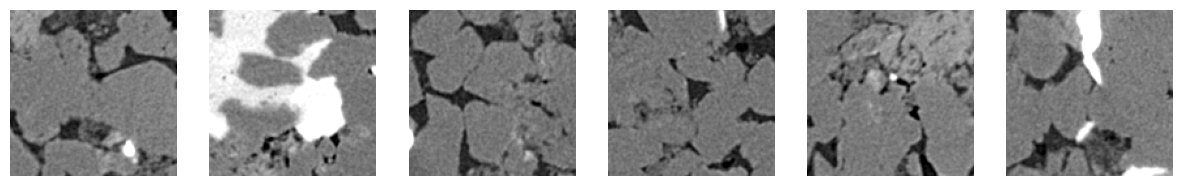

In [8]:
n_samples = 6
random_samples = random.choices(images, k=n_samples)
fig = plt.figure(figsize=(15, 15))

for i, sample in enumerate(random_samples):
  fig.add_subplot(1, n_samples, i+1)
  plt.imshow(sample, cmap='gray')
  plt.axis('off')

### 3.3 View masks

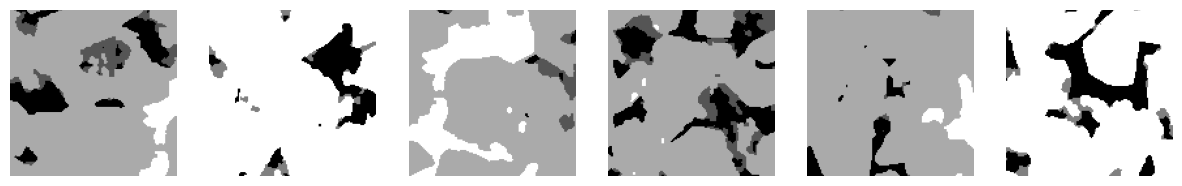

In [9]:
n_samples = 6
random_masks = random.choices(masks, k=n_samples)
fig = plt.figure(figsize=(15, 15))

for i, mask in enumerate(random_masks):
  fig.add_subplot(1, n_samples, i+1)
  plt.imshow(mask, cmap='gray')
  plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

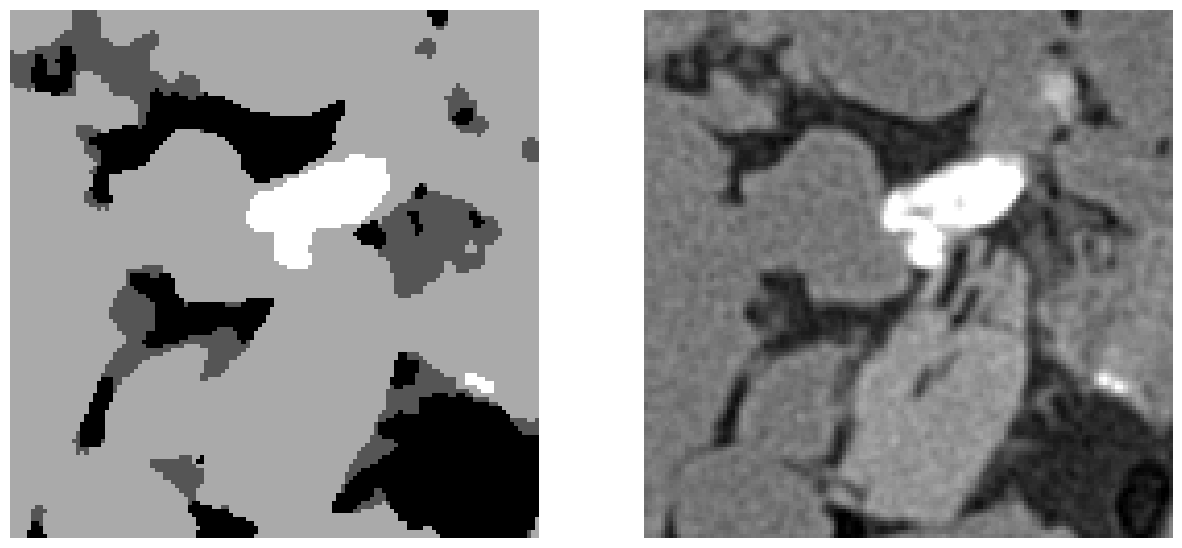

In [10]:
random_n = random.randint(0, len(masks))

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(masks[random_n], cmap='gray')
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(images[random_n], cmap='gray')
plt.axis('off')


### 3.4 Preprocessing the dataset

In [11]:
# Transforms images and masks in ndarrays
train_images = np.array(images)
train_masks = np.array(masks)

In [12]:
np.unique(train_masks)

array([1, 2, 3, 4], dtype=uint8)

In [13]:
# Encode the labels
label_encoder = LabelEncoder()

# To encode our labels we need flatten it
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.flatten()
train_masks_reshaped_encoded = label_encoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

In [14]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3])

In [15]:
# Normilizing images
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks = np.expand_dims(train_masks_encoded_original_shape, axis=3)

### 3.5 Split the data

In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_images, train_masks, test_size=0.2)

In [17]:
np.unique(y_train)

array([0, 1, 2, 3])

In [18]:
train_masks_cat = to_categorical(y_train, n_classes)
train_masks_cat = train_masks_cat.reshape(train_masks_cat.shape[0], train_masks_cat.shape[1], train_masks_cat.shape[2], train_masks_cat.shape[3])

test_masks_cat = to_categorical(y_test, n_classes)
test_masks_cat = test_masks_cat.reshape(test_masks_cat.shape[0], test_masks_cat.shape[1], test_masks_cat.shape[2], test_masks_cat.shape[3])

### 3.6 Balance classes

In [19]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_masks_reshaped_encoded),
                                                  y=train_masks_reshaped_encoded)

In [20]:
class_weights

array([1.93354786, 3.07345989, 0.32786918, 9.30640739])

## 4. Build the Unet model

In [21]:
def conv_block(input, num_filters):
  x = Conv2D(filters=num_filters, # Output filters
             kernel_size=(3, 3),
             padding='same')(input) # Keep the same size
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = Conv2D(filters=num_filters,
             kernel_size=(3, 3),
             padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  return x

def encoder_miniblock(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D(pool_size=(2, 2))(x)
  return x, p

def decoder_miniblock(input, skip_features, num_filters):
  x = Conv2DTranspose(filters=num_filters,
                      kernel_size=(2, 2),
                      strides=(2, 2),
                      padding='same')(input)

  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def unet(input_shape, n_classes):
  inputs = Input(input_shape)
  base_filters = 64

  # Encoder
  skip1, p1 = encoder_miniblock(inputs, base_filters)
  skip2, p2 = encoder_miniblock(p1, base_filters*2)
  skip3, p3 = encoder_miniblock(p2, base_filters*4)
  skip4, p4 = encoder_miniblock(p3, base_filters*8)

  b1 = conv_block(p4, base_filters*16)

  # Decoder
  d1 = decoder_miniblock(b1, skip4, base_filters*8)
  d2 = decoder_miniblock(d1, skip3, base_filters*4)
  d3 = decoder_miniblock(d2, skip2, base_filters*2)
  d4 = decoder_miniblock(d3, skip1, base_filters)

  outputs = Conv2D(filters=n_classes,
                   kernel_size=1,
                   padding='same',
                   activation='softmax')(d4)

  model = Model(inputs, outputs, name='Unet')
  return model

In [ ]:
unet_model = unet((SIZE_X, SIZE_Y, 1), n_classes)
unet_model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 128, 128, 64)         256       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_1 (ReLU)              (None, 128, 128, 64)         0         ['batch_normalization_1[0][

## 5. Compile and Train the mode

In [ ]:
# Compile the mode
unet_model.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.IoU(num_classes=4, target_class_ids=[0, 1, 2, 3])])

In [ ]:
history = unet_model.fit(x=x_train,
                         y=train_masks_cat,
                         batch_size=32,
                         epochs=100,
                         validation_data=(x_test, test_masks_cat),
                         class_weight=dict(enumerate(class_weights)))

Epoch 1/100
40/40 [==============================] - 39s 311ms/step - loss: 0.6586 - accuracy: 0.6645 - io_u: 0.3750 - val_loss: 1.3714 - val_accuracy: 0.0891 - val_io_u: 0.3750
Epoch 2/100
40/40 [==============================] - 12s 296ms/step - loss: 0.3650 - accuracy: 0.8323 - io_u: 0.3750 - val_loss: 1.5052 - val_accuracy: 0.0621 - val_io_u: 0.3750
Epoch 3/100
40/40 [==============================] - 12s 298ms/step - loss: 0.3001 - accuracy: 0.8697 - io_u: 0.3750 - val_loss: 1.9602 - val_accuracy: 0.0460 - val_io_u: 0.3750
Epoch 4/100
40/40 [==============================] - 12s 302ms/step - loss: 0.2664 - accuracy: 0.8859 - io_u: 0.3750 - val_loss: 1.8458 - val_accuracy: 0.0516 - val_io_u: 0.3750
Epoch 5/100
40/40 [==============================] - 12s 295ms/step - loss: 0.2302 - accuracy: 0.8981 - io_u: 0.3750 - val_loss: 3.5014 - val_accuracy: 0.0293 - val_io_u: 0.3750
Epoch 6/100
40/40 [==============================] - 12s 291ms/step - loss: 0.2178 - accuracy: 0.9014 - io_u: 

In [ ]:
history.history

{'loss': [0.6585944890975952,
  0.36500224471092224,
  0.30007603764533997,
  0.26643985509872437,
  0.23016686737537384,
  0.21779796481132507,
  0.1881577968597412,
  0.1741306483745575,
  0.15761668980121613,
  0.145406574010849,
  0.13914915919303894,
  0.12715460360050201,
  0.11644855886697769,
  0.1083105206489563,
  0.10242774337530136,
  0.09762287884950638,
  0.09592009335756302,
  0.1008056029677391,
  0.0831592008471489,
  0.0746859610080719,
  0.07309361547231674,
  0.06944798678159714,
  0.06823161244392395,
  0.06998656690120697,
  0.06265672296285629,
  0.057639848440885544,
  0.05649925023317337,
  0.05614396184682846,
  0.05573555827140808,
  0.05419502407312393,
  0.05614738538861275,
  0.050865910947322845,
  0.049973662942647934,
  0.04602169618010521,
  0.04375861957669258,
  0.04434680566191673,
  0.04410721734166145,
  0.04316110908985138,
  0.04198385030031204,
  0.04099339619278908,
  0.040139827877283096,
  0.03871507570147514,
  0.04061293601989746,
  0.0388

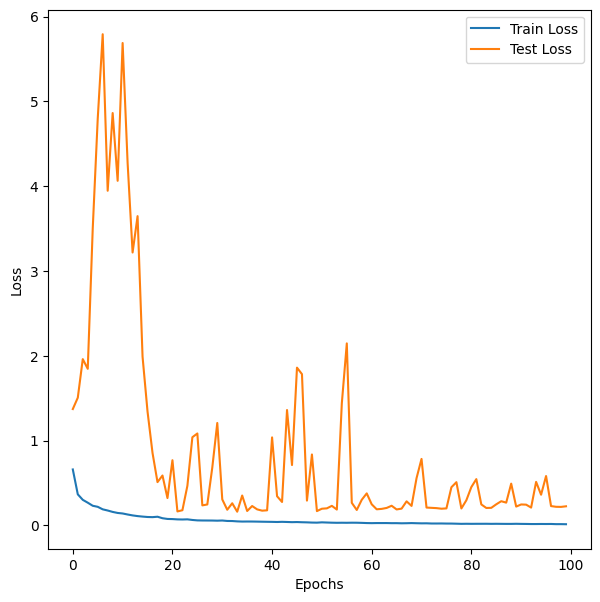

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Train Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

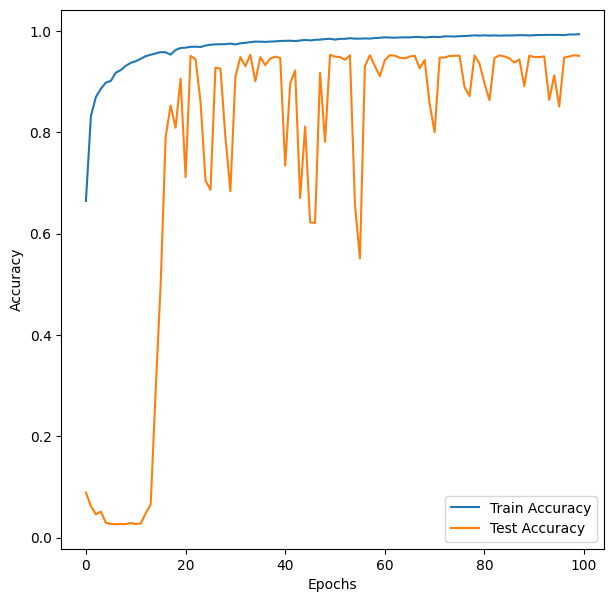

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Train Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

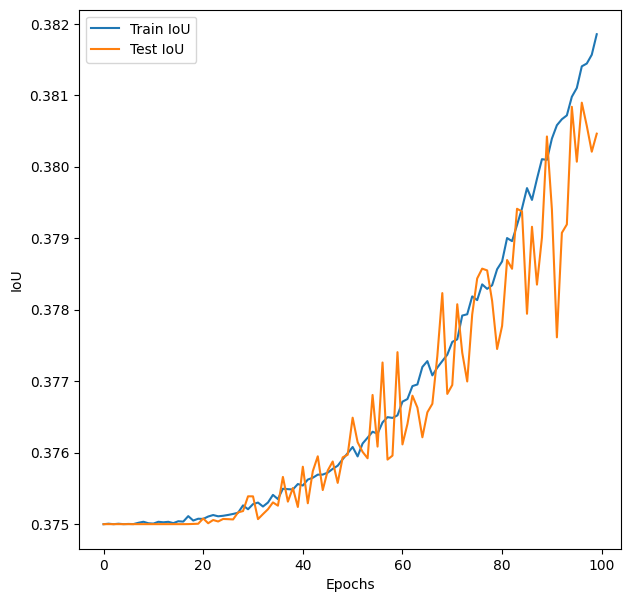

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(range(len(history.history['io_u'])), history.history['io_u'], label='Train IoU')
plt.plot(range(len(history.history['val_io_u'])), history.history['val_io_u'], label='Test IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

## 6. Saving the model

In [ ]:
unet_model.save(filepath='/content/unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6 Load the model and make some predicts

In [29]:
unet_model = tf.keras.models.load_model('/content/unet_model.h5', compile=False)

In [63]:
x_test.shape

(320, 128, 128, 1)

1/1 [==============================] - 0s 45ms/step


<Figure size 1500x1500 with 0 Axes>

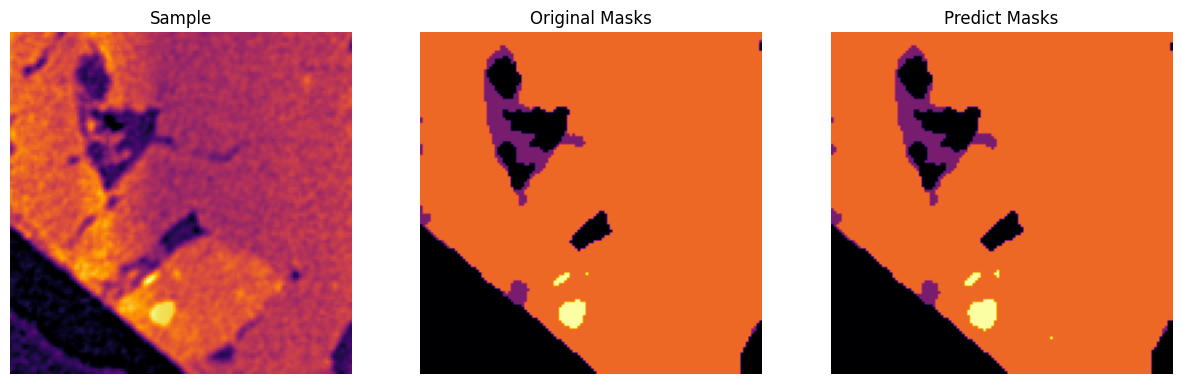

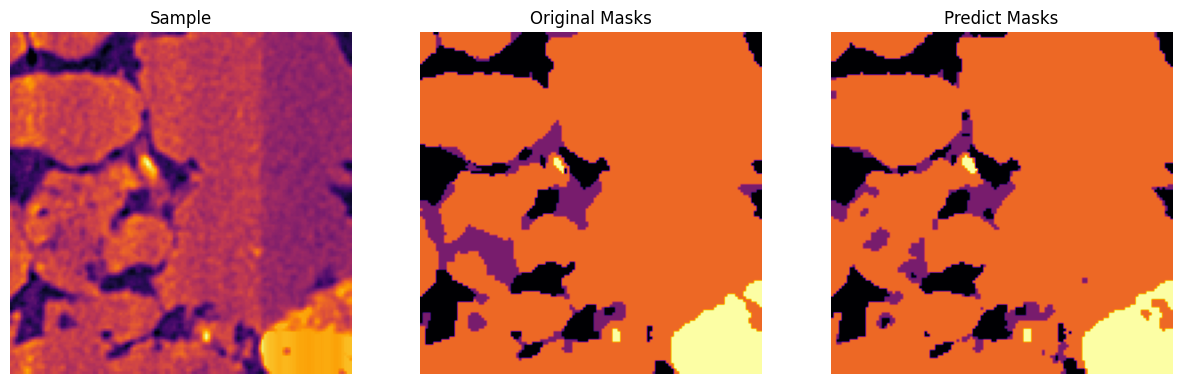

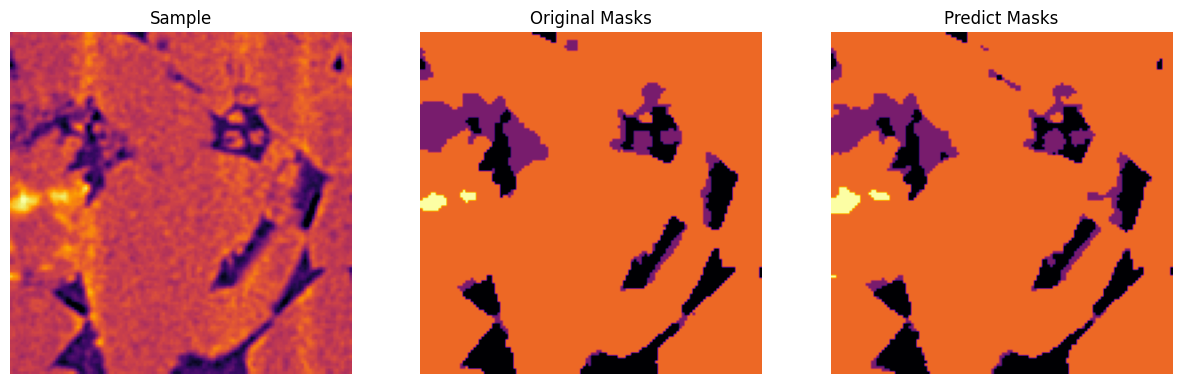

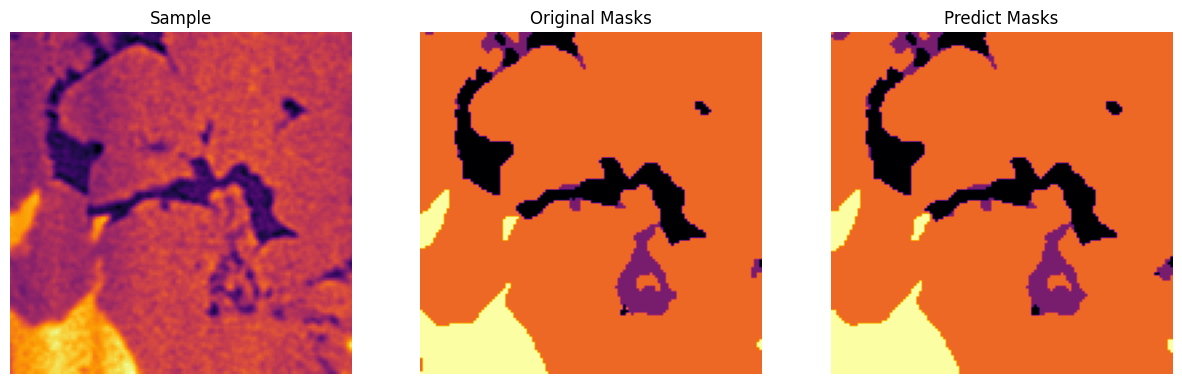

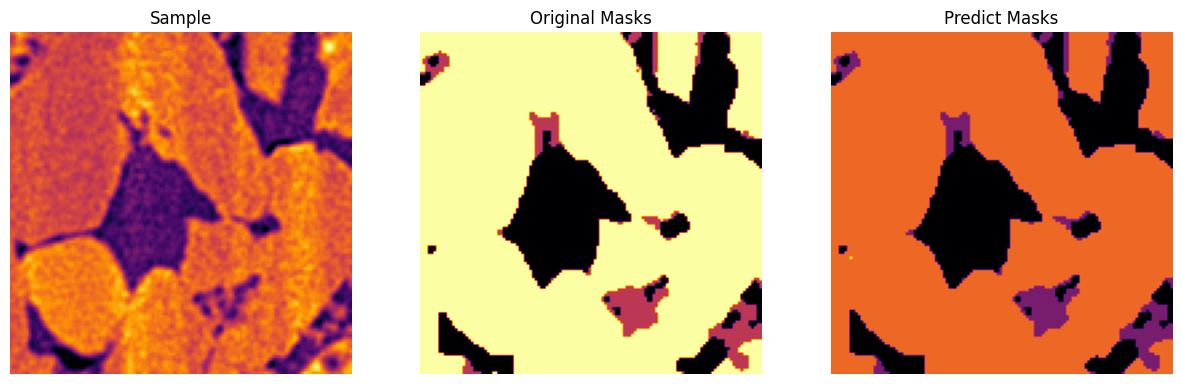

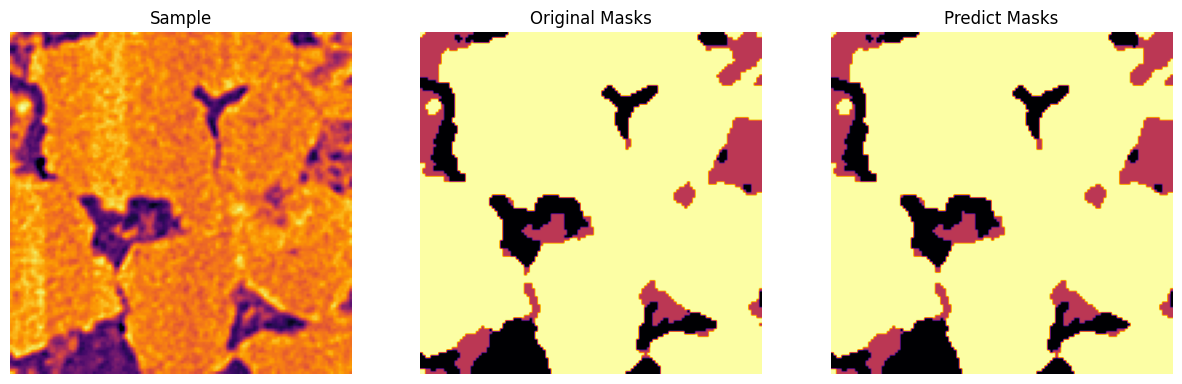

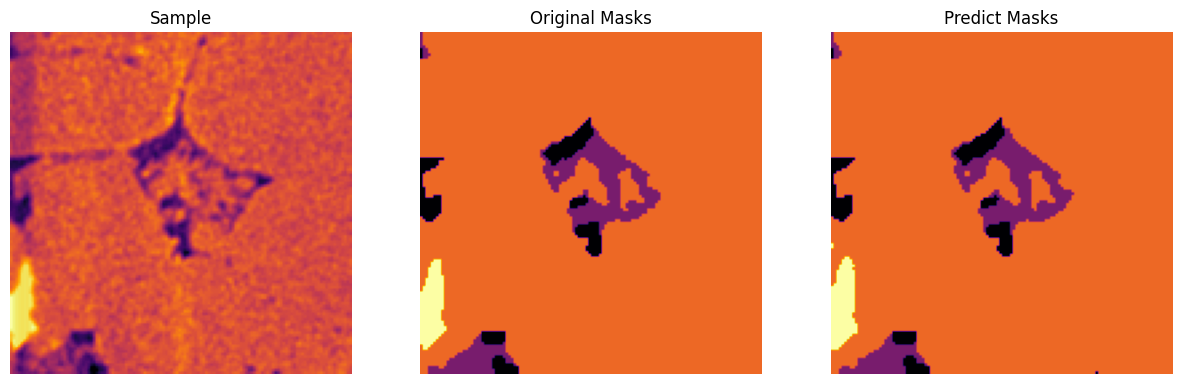

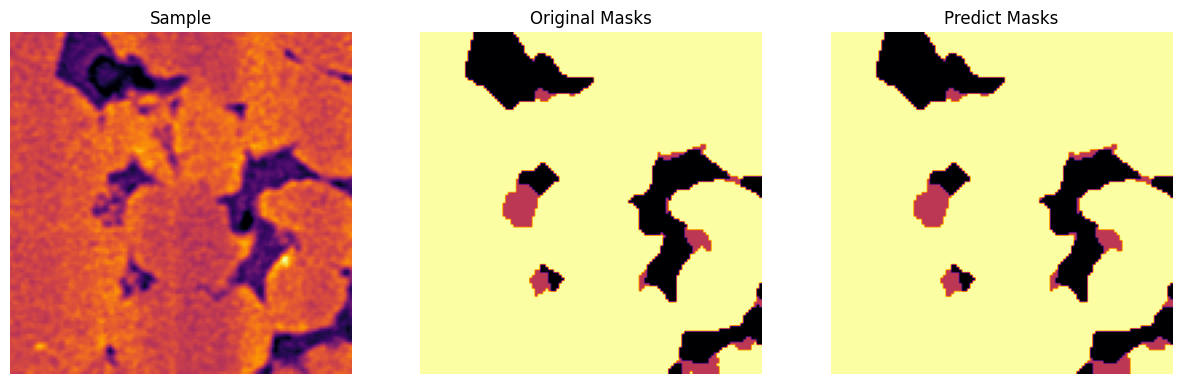

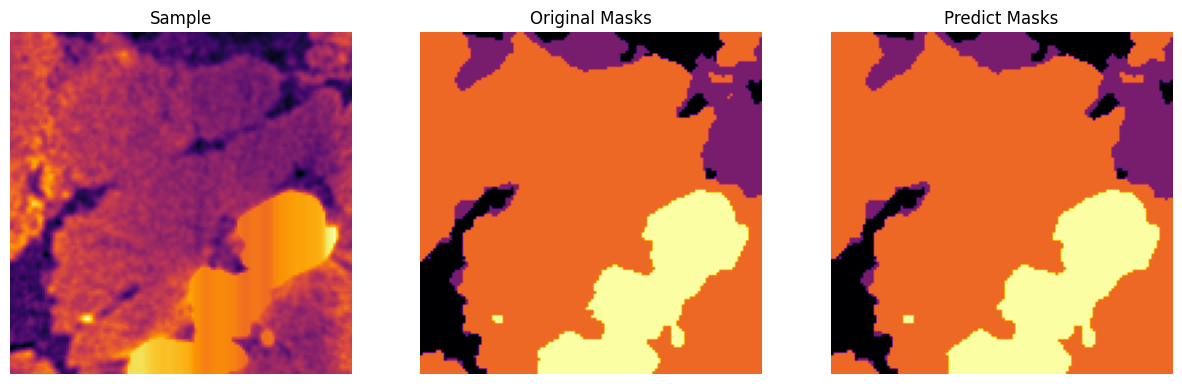

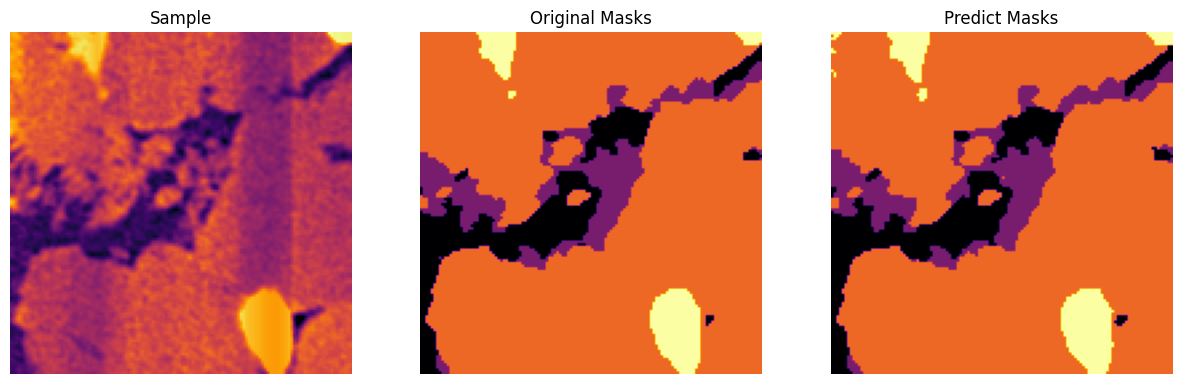

In [66]:
def predict(dataset, masks, n_samples=5) -> None:
  indexes = random.sample(range(len(dataset)), n_samples)

  predicts = unet_model.predict(dataset[[indexes]].squeeze(0))
  predicts = tf.argmax(predicts, 3)

  fig = plt.figure(figsize=(15, 15))

  c = 0
  for i, mask in zip(indexes, predicts):
    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 3, 1)
    plt.imshow(dataset[i], cmap='inferno')
    plt.title("Sample")
    plt.axis('off')

    fig.add_subplot(1, 3, 2)
    plt.imshow(masks[i], cmap='inferno')
    plt.title("Original Masks")
    plt.axis('off')

    fig.add_subplot(1, 3, 3)
    plt.imshow(predicts[c], cmap='inferno')
    plt.title("Predict Masks")
    plt.axis('off')
    c+=1


predict(x_test, y_test, 10)